In [2]:
%matplotlib notebook

from DataSets import *
from MalardClient.MalardClient import MalardClient
from MalardClient.DataSet import DataSet
from MalardClient.BoundingBox import BoundingBox
#from RegressionRun import *
import matplotlib as mpl
import pandas as pd
import numpy.ma as ma
#from MalardClient import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize
from datetime import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statistics import stdev 


In [34]:
# read file
dfTimeseries = pd.read_json("timeseries_results/alaska-refDiff.json")
#elevation change
dfStats = gp.read_file("regression_results/alaska-mad-tdx.gpkg")
#dfTimeseries

In [35]:
# get number of 3 month time intervals that contain data
def unique_3m(timeseries):
    if timeseries is not None:
        return len(set(timeseries))-1
    else:
        return None

dfTimeseries['unique_3m']=dfTimeseries.apply(lambda x: unique_3m(x['timeseries.{}'.format('averages')]), axis=1)

In [80]:
# stdev of timeseries
#def std_3m(timeseries):
#    if timeseries is not None:
#        res = [i for i in timeseries if i]
#        return np.std(np.array(res))
#    else:
#        return None

#dfTimeseries['std_3m']=dfTimeseries.apply(lambda x: std_3m(x['timeseries.{}'.format('averages')]), axis=1)

In [36]:
for idx, line in dfTimeseries.iloc[:2].iterrows():
    dates=[datetime.fromtimestamp(x/1000) for x in line['timeseries.dates']]

In [37]:
client = MalardClient()
parentDs = "mtngla"
inputDataSet = "ReadyDataAlaska2"
region = "alaska"
dataSet = DataSet(parentDs=parentDs, dataSet=inputDataSet, region=region)
projection = client.getProjection(dataSet).proj4

bbx = client.boundingBox(dataSet)
minT = bbx.minT
maxT = bbx.maxT

filters = [{'column':'power','op':'gt','threshold':10000},{'column':'coh','op':'gt','threshold':0.6}, \
                    {'column':'demDiff','op':'lt','threshold':100}, {'column':'demDiffMad','op':'lt','threshold':10}, \
                    {'column':'demDiff','op':'gt','threshold':-100}, {'column':'demDiffMad','op':'gt','threshold':-10}, \
                    {'column':'refDifference','op':'gt','threshold':-150}, {'column':'refDifference','op':'lt','threshold':150}, \
                    {'column':'within_DataSet','op':'gt','threshold':1}]

interval = 3
startdate = min(dates)
enddate = max(dates)

In [38]:
def getData(minX, maxX, minY, maxY):
    bbx_in = BoundingBox(minX, maxX, minY, maxY, minT, maxT)
    result = client.executeQuery(dataSet, bbx_in, projections=[], filters=filters)
    data = PointDataSet(result.resultFileName, projection)
    dateobjects = []
    for i, row in data.data.iterrows():
        date = datetime.utcfromtimestamp(data.data.time[i])
        dateobjects.append(date)
    data.data['dateobject'] = dateobjects

    use_date = startdate
    while use_date <= enddate:
        data.data.loc[(data.data.dateobject >= use_date) & (data.data.dateobject <(use_date+relativedelta(months=+interval))), 'date_class'] = use_date
        use_date = use_date+relativedelta(months=+interval)
    return data.data


In [39]:
# plot preparation:

dfStats.loc[(dfStats['statistics.GlacierMaskArea']<10.0), 'statistics.GlacierMaskArea.pointsize'] = 5
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=10.0) & (dfStats['statistics.GlacierMaskArea']<100.0), 'statistics.GlacierMaskArea.pointsize'] = 20
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=100.0) & (dfStats['statistics.GlacierMaskArea']<500.0), 'statistics.GlacierMaskArea.pointsize'] = 50
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=500.0) & (dfStats['statistics.GlacierMaskArea']<1000.0), 'statistics.GlacierMaskArea.pointsize'] = 80
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>=1000.0) & (dfStats['statistics.GlacierMaskArea']<2000.0), 'statistics.GlacierMaskArea.pointsize'] = 125
dfStats.loc[(dfStats['statistics.GlacierMaskArea']>2000.0), 'statistics.GlacierMaskArea.pointsize'] = 170

coastline = gp.read_file('/data/puma1/scratch/mtngla/background-shapefiles/alaska/coastline.shp')

colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
n_bin = 98  # Discretizes the interpolation into bins
# Create the colormap
cm_ = LinearSegmentedColormap.from_list('my_list', colors, N=n_bin)
cm = LinearSegmentedColormap.from_list('extremes',list(map(cm_,range(100))), N=100)
vmin=-2
vmax=2
labels = ["<10", "10-100", "100-500", "500-1000", "1000-2000", ">2000"]
sizes = [5, 20, 50, 80, 125, 170]



In [47]:
def plotDash(row, regression, timeseries, reg_plot, details=False, detail=None, detailtype=None):
    gridcellMinX = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minX']
    gridcellMinY = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.minY']
    size = dfTimeseries.loc[dfTimeseries.index[row], 'gridCell.size']
    regression_line = dfStats[(dfStats['gridCell.minX']==gridcellMinX)&(dfStats['gridCell.minY']==gridcellMinY)]
    print('Glacier mask area: %.3f km' % (dfTimeseries.iloc[row]['statistics.GlacierMaskArea']))
    print('Total points: stats={}, regression={}, w_power={}, w_power_masked={}'.format(dfTimeseries.iloc[row]['statistics.result_total'], regression_line['regression.count'].values[0], regression_line['regression.w_power.count'].values[0], regression_line['regression.w_power.count_masked'].values[0]))
    print('Points per km2: %s' % (dfTimeseries.iloc[row]['statistics.result_total']/dfTimeseries.iloc[row]['statistics.GlacierMaskArea']))
    pdratio = dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask']/dfTimeseries.iloc[row]['statistics.result_total']*100
    print('Points on debris: %s  \t\t\t Points on debris ratio: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsWithinDebrisMask'], pdratio))
    print('Points on TDX: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue2Ratio']))
    print('Points on AD: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue1Ratio']))
    print('Points on Interp: %.2f percent' % (dfTimeseries.iloc[row]['statistics.pointsOnDataSetValue0Ratio']))
    #print('RSquared: %.2f' % (regression_line['regression.rsquared']))
    print('Elevation change: %.3f m/y \t Robust: %.3f m/y \t w_power: %.3f m/y \t w_coh: %.3f m/y' % (regression_line['regression.c.year'].values[0], regression_line['regression.robust.c.year'].values[0], regression_line['regression.w_power.c.year'].values[0], regression_line['regression.w_coh.c.year'].values[0]))
    print('Standard error: %.3f m \t Robust: %.3f m \t w_power: %.3f m \t w_coh: %.3f m ' % (regression_line['regression.c.se.year'].values[0], regression_line['regression.robust.c.se.year'].values[0], regression_line['regression.w_power.c.se.year'].values[0], regression_line['regression.w_coh.c.se.year'].values[0]))
    print('Regression constant: %.3f m \t\t Robust regression constant: %.3f m' % (regression_line['regression.const'].values[0],regression_line['regression.robust.const'].values[0]))

    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]
    
    if not details:
        fig, ax = plt.subplots(1,2,figsize=(9.8,5.5))
    else:
        fig, ax = plt.subplots(3,1,figsize=(8.8,13.5))
    # 1 plot time series
    ax[1].plot(dates , dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)], linewidth=0.7, marker='^', markersize=2)
    
    print(1)

    # calculate regression prediction
    colors=['red', 'orange', 'yellow', 'green']
    for i,reg in enumerate(reg_plot):
        reg=reg+'.'
        minTime = datetime.timestamp(min(dates))
        maxTime = datetime.timestamp(max(dates))
        minTimeValue = regression_line['regression.{}c'.format(reg)].values*minTime+regression_line['regression.{}const'.format(reg)].values
        maxTimeValue = regression_line['regression.{}c'.format(reg)].values*maxTime+regression_line['regression.{}const'.format(reg)].values
        predict_v = [minTimeValue[0],maxTimeValue[0]]
    
        # add regression line
        ax[1].plot([min(dates), max(dates)], predict_v, color=colors[i], linewidth=0.5, label=reg)

    print(2)
    # more things are plotted
    if details:
        size=int(regression_line['gridCell.size'].values[0])
        minX=int(regression_line['gridCell.minX'].values[0])
        maxX=minX+size
        minY=int(regression_line['gridCell.minY'].values[0])
        maxY=minY+size
        dta = getData(minX=minX, maxX=maxX, minY=minY, maxY=maxY)
        counts=dta.groupby('date_class').index.count()/dfTimeseries.iloc[row]['statistics.GlacierMaskArea']
        keys = list(dta.groupby('date_class').groups.keys())
        ax_left = ax[1].twinx()
        ax_left.scatter(keys, counts, color='grey', label='counts', marker='o', s=5)
        pos = ax[2].get_position() # get the original position 
        addXAx=(pos.x1-pos.x0)/7
        #addYAx=(pos.y1-pos.y0)/6
        incX=0
        incY=0
        sem = []
        for i,date in enumerate(list(dta.groupby('date_class').groups.keys())):
            x=pos.x0+incX
            y=0.3+incY
            incX=incX+addXAx
            s=i+1
            if s%8==0:
                incX= 0
                incY=incY-0.06
            a = plt.axes([x, y, .07, .03], facecolor='lightgrey')
            filt=dta[dta['date_class']==date]
            if detailtype=='hist':
                filt[detail].hist()
            elif detailtype=='pie':
                filt[detail].plot.pie()
            else:
                filt[detail].plot()
            plt.xticks(fontsize = 6)
            plt.yticks(fontsize = 6)
            plt.title(i, fontsize = 7, pad=0.1)
            sem.append(filt['refDifference'].sem())
        ax[1].errorbar(x=dates , y=dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)], yerr=sem, capsize=1.5, linewidth=0.7, marker='^', markersize=2, color='blue', ecolor='red')
     
        ax[2].get_xaxis().set_visible(False)
        ax[2].get_yaxis().set_visible(False)
        ax[2].axis('off')
        valsNotNone = [x for x in dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)] if x is not None]
        for idx, d in enumerate(list(dta.groupby('date_class').groups.keys())):
            ax[1].annotate(idx, (d, valsNotNone[idx]), fontsize=8)
            #dfTimeseries.iloc[row]['timeseries.{}'.format(timeseries)][idx]
    
    # finish ax1
    ax[1].set_xlim(min(dates), max(dates))
    ax[1].set_xlabel('Years')
    ax[1].set_ylabel('Elevation change ({}) [m]'.format(timeseries))
    ax[1].legend()
    
    # 2 plot map
    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax[0])

    markersize = dfStats['statistics.GlacierMaskArea.pointsize']

    regression=regression+'.'
    dfStats.plot(column='regression.{}c.year'.format(regression), markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax[0])
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    ax[0].legend(handles=markers)
    leg = ax[0].legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [km2]', scatterpoints = 1, labelspacing=1.5)

    #ax[0].set_ylim(-2000000, 1000000)
    #ax[0].set_xlim(-900000, 1700000)
    # add number of gridcell
    for i, txt in enumerate(dfTimeseries['statistics.result_total']):
        ax[0].annotate(i, (dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minX']+ \
                               (size/2)+10000, dfTimeseries.loc[dfTimeseries.index[i], 'gridCell.minY']+\
                               (size/2)+10000), fontsize=5)
    # add X
    ax[0].annotate('x', (gridcellMinX+(size/2)-30000, gridcellMinY+(size/2)-30000), fontsize=12)
    ax[0].set_xlim(-5000000, -2700000)
    ax[0].set_ylim(-900000, 1700000)
    
    ax[1].set_xlim(min(dates), max(dates))

    if not details:
        bar=fig.colorbar(ax=ax[1], orientation='horizontal',  pad=0.35, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
        bar.set_label('Elevation change per year [m]')
        plt.tight_layout()
        ax[1].yaxis.tick_right()
        ax[1].yaxis.set_label_position("right")
        
    

Glacier mask area: 56.170 km
Total points: stats=991, regression=4200.0, w_power=4062.0, w_power_masked=138.0
Points per km2: 17.6427879467211
Points on debris: 57  			 Points on debris ratio: 5.75 percent
Points on TDX: 88.19 percent
Points on AD: nan percent
Points on Interp: 11.81 percent
Elevation change: -3.717 m/y 	 Robust: -2.943 m/y 	 w_power: -3.736 m/y 	 w_coh: -3.245 m/y
Standard error: 0.147 m 	 Robust: 0.090 m 	 w_power: 0.110 m 	 w_coh: 0.119 m 
Regression constant: 156.250 m 		 Robust regression constant: 125.007 m


<IPython.core.display.Javascript object>


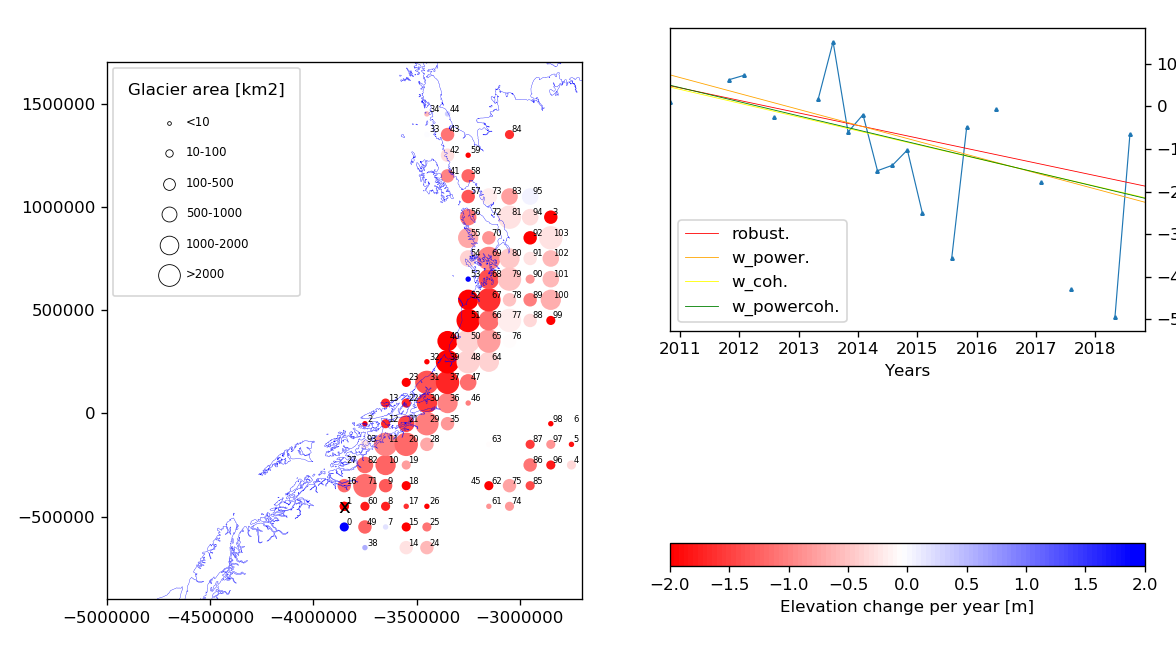

1
2


In [48]:
%matplotlib notebook
# change this
row=1
reg_map='w_powercoh'
reg_plot=['robust','w_power','w_coh', 'w_powercoh']
timeseries='averages'
plotDash(row, reg_map, timeseries, reg_plot)

In [50]:
%matplotlib notebook
# change this
row=1
reg_map='w_power'
reg_plot=['robust','w_power','w_coh']
timeseries='power'
plotDash(row, reg_map, timeseries, reg_plot, details=True, detail='elev', detailtype='hist')

Glacier mask area: 56.170 km
Total points: stats=991, regression=4200.0, w_power=4062.0, w_power_masked=138.0
Points per km2: 17.6427879467211
Points on debris: 57  			 Points on debris ratio: 5.75 percent
Points on TDX: 88.19 percent
Points on AD: nan percent
Points on Interp: 11.81 percent
Elevation change: -3.717 m/y 	 Robust: -2.943 m/y 	 w_power: -3.736 m/y 	 w_coh: -3.245 m/y
Standard error: 0.147 m 	 Robust: 0.090 m 	 w_power: 0.110 m 	 w_coh: 0.119 m 
Regression constant: 156.250 m 		 Robust regression constant: 125.007 m


<IPython.core.display.Javascript object>

KeyError: 'timeseries.power'

<IPython.core.display.Javascript object>


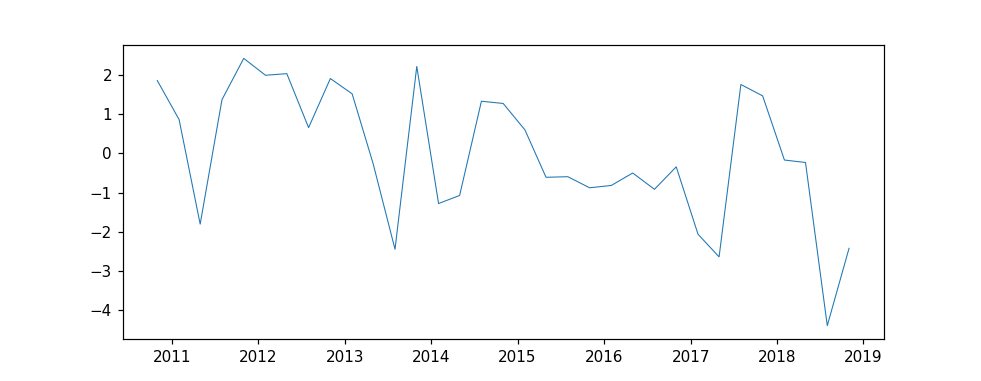

In [26]:
%matplotlib notebook
plt.figure(figsize=(9,3.5))

row=dfTimeseries.loc[(dfStats['gridCell.minX']==500000) & (dfStats['gridCell.minY']==-300000)]
 
dates=[datetime.fromtimestamp(x/1000) for x in row.iloc[0]['timeseries.dates']]
plt.plot(dates , row.iloc[0]['timeseries.averages'], linewidth=0.7)

In [28]:
def plotTS(row):
    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(figsize=(8,5))
    # time series
    ax.plot(dates , dfTimeseries.iloc[row]['timeseries.averages'], linewidth=0.7)

    ax.set_xlim(min(dates), max(dates))
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean elevation difference to reference DEM [m]')
    #ax[1].yaxis.tick_right()
    #ax[1].yaxis.set_label_position("right")
    plt.title('3-Month time series')

    plt.tight_layout()
    

<IPython.core.display.Javascript object>


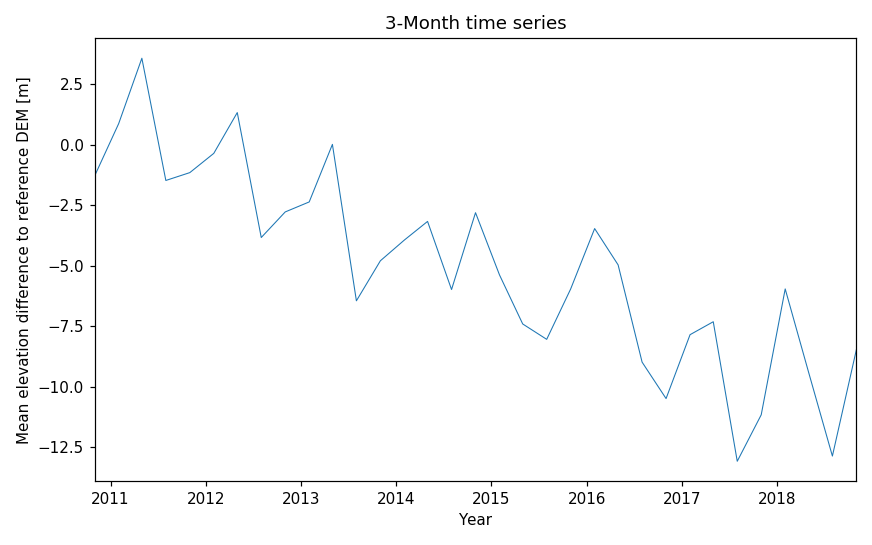

In [29]:
plotTS(114)

In [51]:
# merge the two datasets
dfStatsMerge = dfStats.merge(dfTimeseries, how='left', on=['gridCell.minX','gridCell.minY'])

In [54]:
# stdev of timeseries
def std_3m(timeseries, dates, rate, const):
    if timeseries is not None and timeseries is not np.nan:
        ratesremoved=[]
        for i,date in enumerate(dates):
            if timeseries[i] is not None:
                reg_value = const+(rate*(date/1000))
                ratesremoved.append(timeseries[i]-reg_value)
        #res = [i for i in timeseries if i]
        return np.std(np.array(ratesremoved))
    else:
        return None

dfStatsMerge['std_3m']=dfStatsMerge.apply(lambda x: std_3m(x['timeseries.{}'.format('averages')], x['timeseries.{}'.format('dates')], x['regression.{}.c'.format('w_powercoh')], x['regression.{}.const'.format('w_powercoh')]), axis=1)
#dfStats['std_3m']=dfStats.apply(lambda x: std_3m(x['timeseries.{}'.format('averages')], x['timeseries.{}'.format('dates')], x['regression.{}.c'.format('w_powercoh')], x['regression.{}.const'.format('w_powercoh')]), axis=1)

In [56]:
def plotMap():
    markersize = dfStats['statistics.GlacierMaskArea.pointsize']
    dates=[datetime.fromtimestamp(x/1000) for x in dfTimeseries.iloc[row]['timeseries.dates']]

    fig, ax = plt.subplots(figsize=(7,7))

    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax)

    dfStats.plot(column='regression.w_power.c.year', markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax)
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    bar.set_label('Elevation change [m/yr]')

    ax.legend(handles=markers)
    leg = ax.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [$km^2$]', scatterpoints = 1, labelspacing=1.5)
    #plt.title('DhDt Himalayas')
    ax.set_xlim(-5000000, -2700000)
    ax.set_ylim(-900000, 1700000)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])

<IPython.core.display.Javascript object>


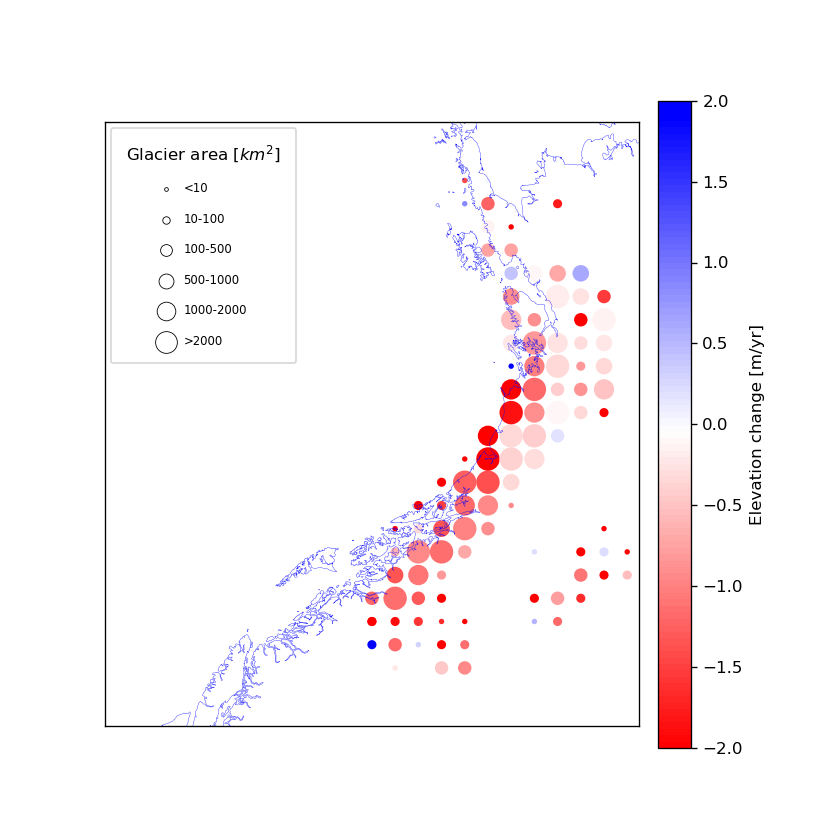

In [57]:
plotMap()

In [58]:
dfStatsLowError=dfStats[(dfStats['regression.noel.w_powercoh.error']<1) & (dfStats['regression.w_powercoh.time_unique']>30)]
dfStatsMergeError=dfStatsMerge[(dfStatsMerge['regression.noel.w_powercoh.error']<1) & (dfStatsMerge['unique_3m']>28) & (dfStatsMerge['std_3m']<25)]

In [59]:
def plotMapErrors(row, lowError, regression, title=''):

    fig, ax = plt.subplots(figsize=(7,7))
    
    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax)

    if lowError:
        markersize = dfStatsMergeError['statistics.GlacierMaskArea.pointsize']
        dfStatsMergeError.plot(column='regression.{}.c.year'.format(regression), markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax)
    else:
        markersize = dfStats['statistics.GlacierMaskArea.pointsize']
        dfStats.plot(column='regression.{}.c.year'.format(regression), markersize=markersize, vmin=vmin, \
                         vmax=vmax, cmap=cm, ax=ax)
        
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm))
    bar.set_label('Elevation change [m/yr]')

    ax.legend(handles=markers)
    leg = ax.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [$km^2$]', scatterpoints = 1, labelspacing=1.5)
    ax.set_xlim(-5000000, -2700000)
    ax.set_ylim(-900000, 1700000)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    ax.set_title(title)

<IPython.core.display.Javascript object>


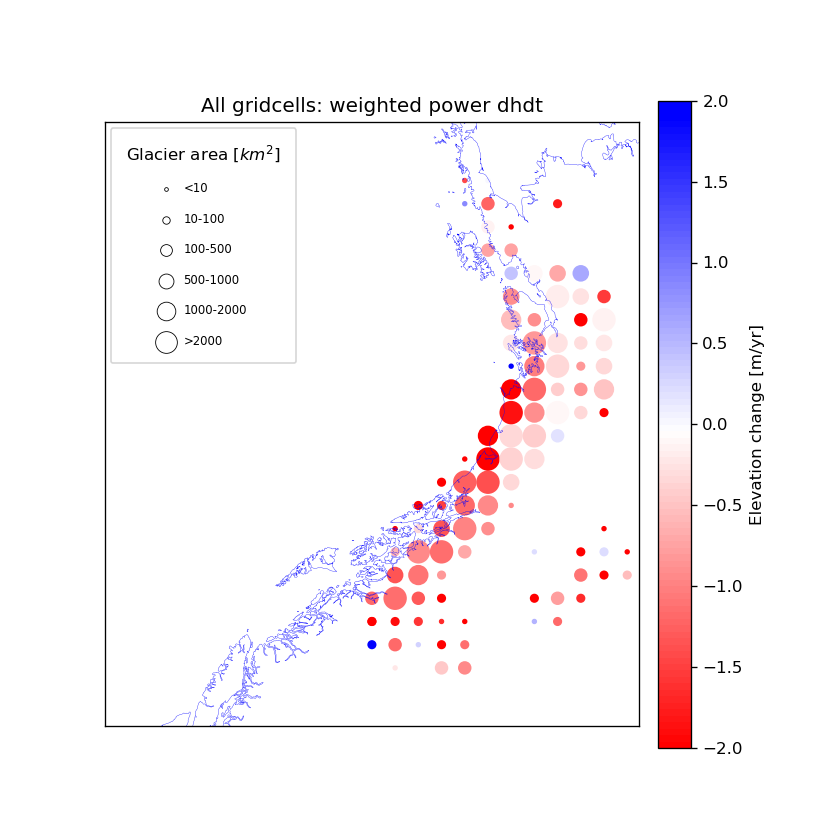

In [60]:
plotMapErrors(0, lowError=False, regression='w_power', title='All gridcells: weighted power dhdt')

<IPython.core.display.Javascript object>


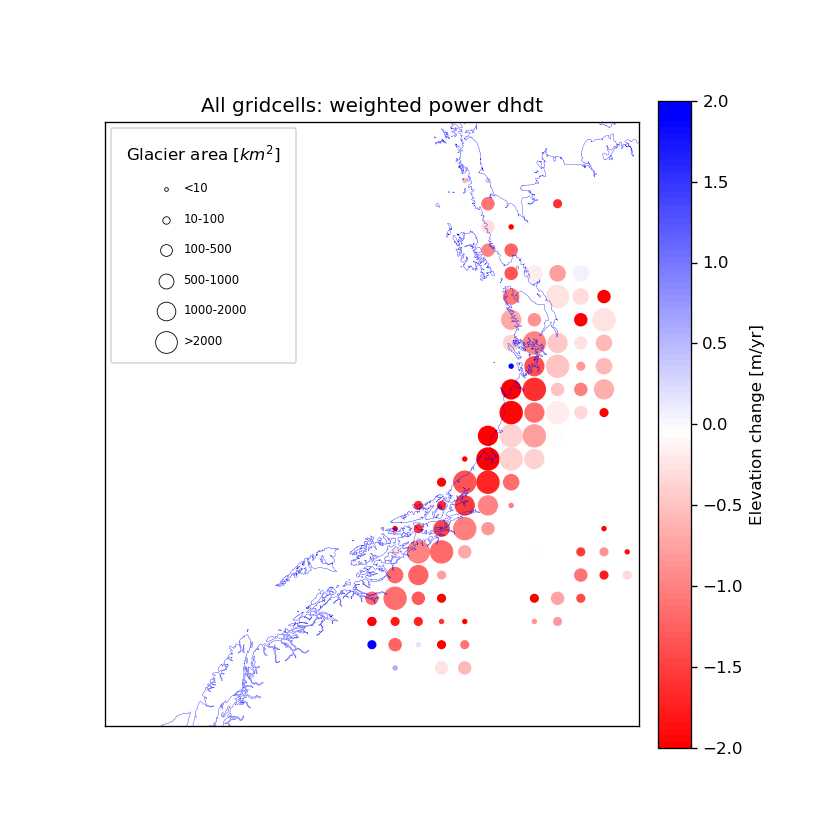

In [61]:
plotMapErrors(0, lowError=False, regression='w_powercoh', title='All gridcells: weighted power dhdt')

<IPython.core.display.Javascript object>


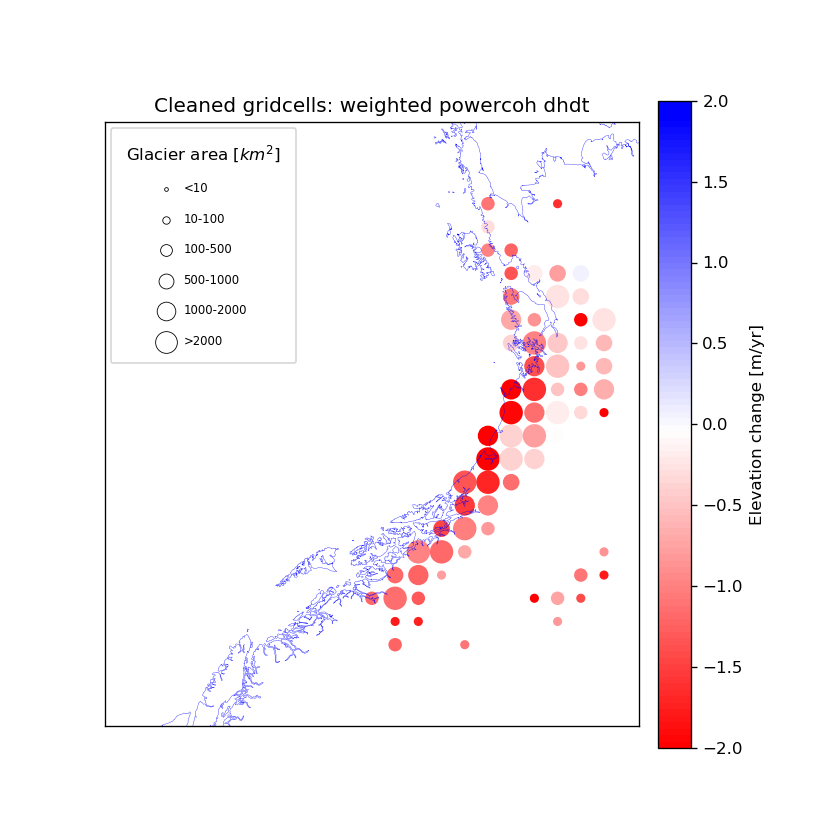

In [64]:
plotMapErrors(0, lowError=True, regression='w_powercoh', title='Cleaned gridcells: weighted powercoh dhdt')

In [65]:
#### MERGE ERRORS
def plotErrors(title=''):
    # change this to change min and max of colors
    mincol=28
    maxcol=29
    
    fig, ax = plt.subplots(figsize=(7,7))

    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax)
    
    dfStatsMergeError=dfStatsMerge[(dfStatsMerge['regression.noel.w_powercoh.error']<1) & (dfStatsMerge['unique_3m']>28) & (dfStatsMerge['std_3m']<25)]
    #markersize = dfStatsMergeError['statistics.GlacierMaskArea.pointsize']
    #dfStats.plot(column='regression.noel.w_power.error', markersize=markersize, vmin=mincol, \
    #  
    markersize = dfStatsMergeError['statistics.GlacierMaskArea.pointsize']
    dfStatsMergeError.plot(column='unique_3m', markersize=markersize, vmin=mincol, \
    vmax=maxcol, ax=ax)
    
    #dfStatsMergeError.plot(column='std_3m', markersize=markersize, vmin=mincol, \
    #                     vmax=maxcol, ax=ax)
    
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mincol, vmax=maxcol), cmap='viridis'))
    bar.set_label('Error [m/yr]')

    ax.legend(handles=markers)
    leg = ax.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [$km^2$]', scatterpoints = 1, labelspacing=1.5)
    ax.set_xlim(-5000000, -2700000)
    ax.set_ylim(-900000, 1700000)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    ax.set_title(title)

<IPython.core.display.Javascript object>


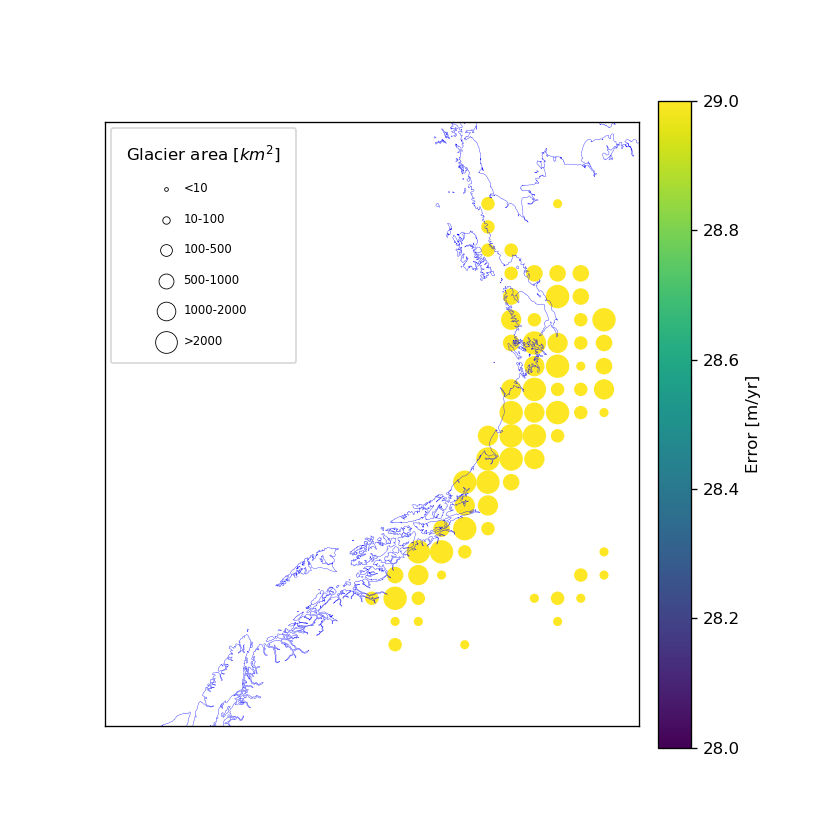

In [66]:
plotErrors()

In [67]:
def plotThresholds(title=''):
    # change this to change min and max of colors
    mincol=100
    maxcol=101
    
    fig, ax = plt.subplots(figsize=(7,7))

    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax)

    markersize = dfStatsLowError['statistics.GlacierMaskArea.pointsize']
    dfStatsLowError.plot(column='regression.w_power.count', markersize=markersize, vmin=mincol, \
                         vmax=maxcol, ax=ax)
        
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mincol, vmax=maxcol), cmap='viridis'))
    bar.set_label('Error [m/yr]')

    ax.legend(handles=markers)
    leg = ax.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [$km^2$]', scatterpoints = 1, labelspacing=1.5)
    ax.set_xlim(-5000000, -2700000)
    ax.set_ylim(-900000, 1700000)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    ax.set_title(title)

<IPython.core.display.Javascript object>


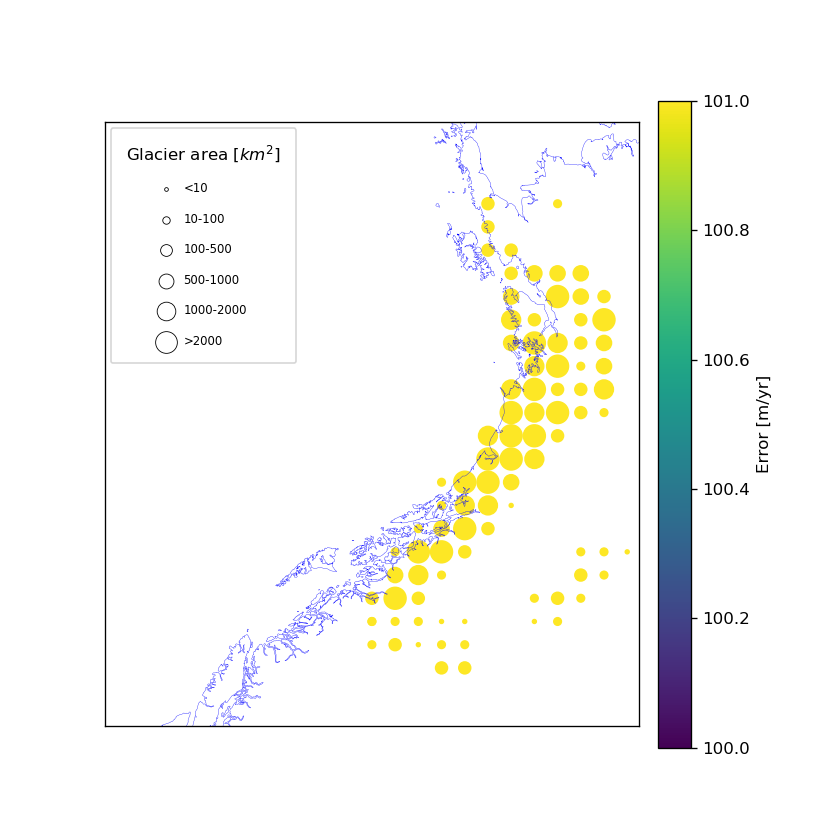

In [68]:
plotThresholds()

In [69]:
# Calculate mass changes
dfStats['mass_change']=(dfStats['regression.w_powercoh.c.year']/1000000)*dfStats['statistics.GlacierMaskArea']*850

In [70]:
dfStats['mass_change'].sum()

-78.83807691188565

In [71]:
dfStatsMergeError['mass_change']=(dfStatsMergeError['regression.w_powercoh.c.year']/1000000)*dfStatsMergeError['statistics.GlacierMaskArea_x']*850

/home/earthwave/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [72]:
dfStatsMergeError['mass_change'].sum()

-77.42134807215258

In [266]:
dfStatsLowError=dfStats[(dfStats['regression.noel.w_powercoh.error']<1) & (dfStats['regression.w_powercoh.time_unique']>30)]
dfStatsLowError['mass_change'].sum()

-29.510808383494386

In [96]:
def plotMassChange(lowError, title=''):
    # change this to change min and max of colors
    mincol=-5
    maxcol=5
    
    fig, ax = plt.subplots(figsize=(7,7))

    coastline.plot(color='blue', edgecolor=None, linewidth=0.2, ax=ax)

    
    if lowError:
        markersize = dfStatsMergeError['statistics.GlacierMaskArea.pointsize']
        dfStatsMergeError.plot(column='mass_change', markersize=markersize, vmin=mincol, \
                         vmax=maxcol, cmap=cm, ax=ax, edgecolor='black', linewidth=0.15)
    else:
        markersize = dfStats['statistics.GlacierMaskArea.pointsize']
        dfStats.plot(column='mass_change', markersize=markersize, vmin=mincol, \
                         vmax=maxcol, cmap=cm, ax=ax, edgecolor='black', linewidth=0.15)
        
    markers=[]
    for s in sizes:
        markers.append(plt.scatter([],[], s=s, label=s, color='white', edgecolor='black', linewidth=0.5))

    bar=fig.colorbar(ax=ax, orientation='vertical', pad=0.03, mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mincol, vmax=maxcol), cmap=cm))
    bar.set_label('Mass change (Gt/yr)')

    ax.legend(handles=markers)
    leg = ax.legend(markers, labels, ncol=1, frameon=True, fontsize=7,handlelength=1, loc = 0, borderpad = 1.3,\
    handletextpad=1, title='Glacier area [$km^2$]', scatterpoints = 1, labelspacing=1.5)
    ax.set_xlim(-5000000, -2700000)
    ax.set_ylim(-900000, 1700000)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.xticks([])
    plt.yticks([])
    ax.set_title(title)

<IPython.core.display.Javascript object>


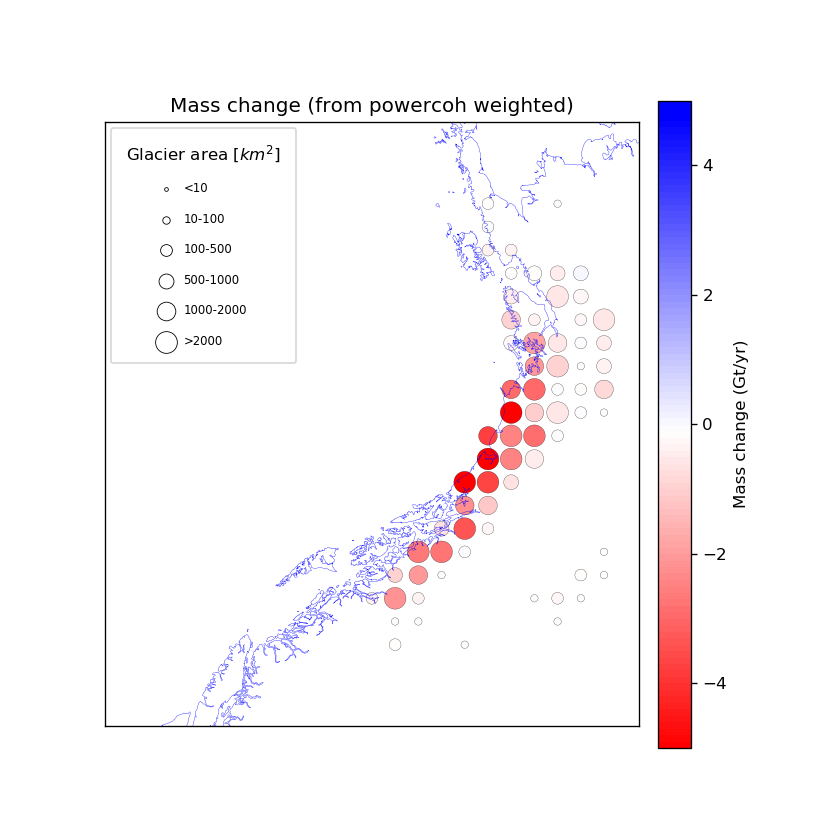

In [97]:
plotMassChange(lowError=True, title='Mass change (from powercoh weighted)')

In [269]:
dfStatsLowError.to_file('/home/livia/QGIS-Projects/mntgla/powercohdhdt.gpkg', driver="GPKG")